# Uvod #

U ovoj vježbi naučit ćete kako poboljšati rezultate treninga uključivanjem povratnog poziva ranog zaustavljanja kako biste spriječili prekomjerno opremanje.

Kada budete spremni, pokrenite ovu sljedeću ćeliju da sve postavite!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



Prvo učitajte skup podataka *Spotify*. Vaš će zadatak biti predvidjeti popularnost pjesme na temelju različitih audio značajki, kao što su `'tempo'`, `'danceability'` i `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./input/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

/Users/dominikgabela/PSU_Labovi/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Input shape: [18]


Počnimo s najjednostavnijom mrežom, linearnim modelom. Ovaj model ima mali kapacitet.

Pokrenite ovu sljedeću ćeliju bez ikakvih promjena za obuku linearnog modela na *Spotify* skupu podataka.

/Users/dominikgabela/PSU_Labovi/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.1960


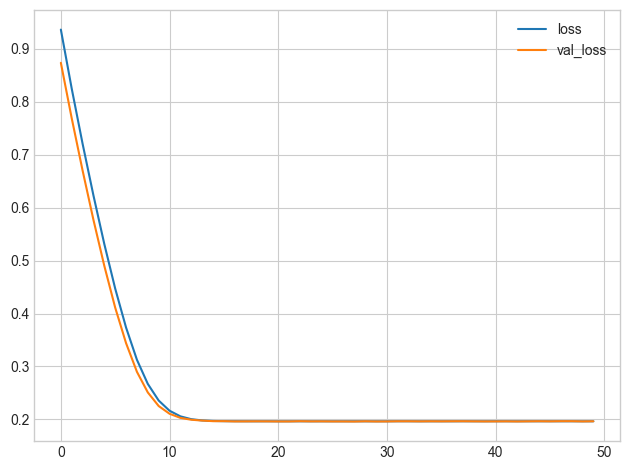

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Nije neuobičajeno da krivulje slijede uzorak "hokejaške palice" kao što vidite ovdje. Zbog toga je završni dio treninga teško vidljiv, pa umjesto toga počnimo od epohe 10:

Minimum Validation Loss: 0.1960


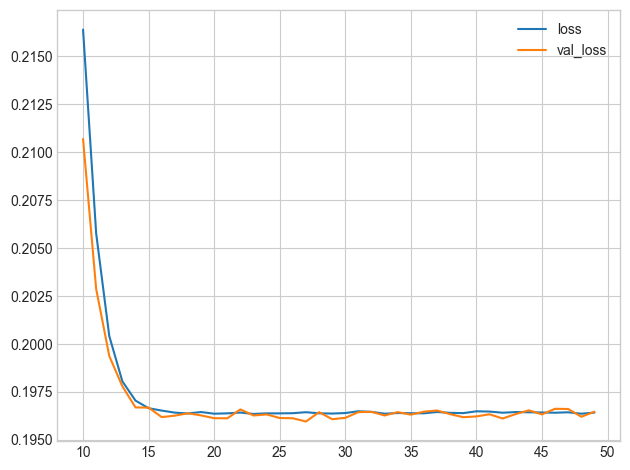

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Procijenite osnovnu liniju

Što misliš? Biste li rekli da je ovaj model underfitting, overfitting, ili baš kako treba?

-Model je overfitting jer se model dovoljno prilagodio podacima za obuku da bi se gubitak na tom skupu smanjio, ali se istodobno generalizacija na neviđene podatke nije poboljšala ili čak pogoršala, što pokazuje porast gubitka na skupu za validaciju.

Sada dodajmo malo kapaciteta našoj mreži. Dodat ćemo tri skrivena sloja sa po 128 jedinica. Pokrenite sljedeću ćeliju da uvježbate mrežu i vidite krivulje učenja.

Epoch 1/50


/Users/dominikgabela/PSU_Labovi/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2821 - val_loss: 0.2076
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2025 - val_loss: 0.2023
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1967 - val_loss: 0.2002
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1925 - val_loss: 0.2005
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1902 - val_loss: 0.1981
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1883 - val_loss: 0.2019
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1878 - val_loss: 0.1965
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1847 - val_loss: 0.1977
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1846 - val_loss: 0.1985
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1832 - val_loss: 0.1984
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1826 - val_loss: 0.1978
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1807 - val_loss: 0.1973


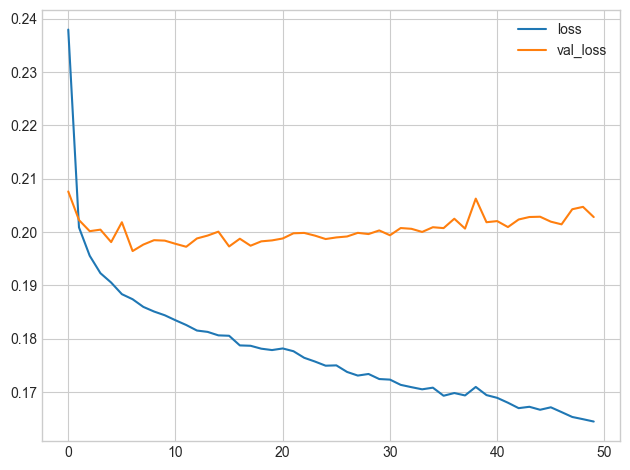

In [5]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Dodajte kapacitet

Kakva je vaša ocjena ovih krivulja? underfitting, overfitting, baš kako treba?

-Model je overfittan:Trenutni gubitak je značajno manji od validacijskog gubitka. To znači da model dobro modelira podatke za treniranje, ali ne i podatke za validaciju. To je klasičan znak overfittiranja.;  Krivulja trenutnog gubitka pokazuje platou u kasnijim epohama. To znači da model više ne uči iz podataka za treniranje, što je još jedan znak overfittiranja;  Krivulja validacijskog gubitka počinje rasti u ranim epohama. To znači da model previše brzo uči iz podataka za treniranje i ne uspijeva generalizirati na podatke za validaciju.

# 3) Definirajte rano zaustavljanje povratnog poziva

Sada definirajte povratni poziv ranog zaustavljanja koji čeka 5 epoha (`patience`) za promjenu u gubitku valjanosti od najmanje `0,001` (`min_delta`) i zadržava težine s najboljim gubitkom (`restore_best_weights`).

In [6]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

Sada pokrenite ovu ćeliju da uvježbate model i dobijete krivulje učenja. Obratite pažnju na argument `callbacks` u `model.fit`.

Epoch 1/50


/Users/dominikgabela/PSU_Labovi/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2616 - val_loss: 0.2039
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2011 - val_loss: 0.2010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1931 - val_loss: 0.1992
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1918 - val_loss: 0.1986
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1889 - val_loss: 0.1985
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1885 - val_loss: 0.1990
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1870 - val_loss: 0.1993
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1850 - val_loss: 0.1973
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1855 - val_loss: 0.1979
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1814 - val_loss: 0.1987
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1845 - val_loss: 0.2009
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1839 - val_loss: 0.1986


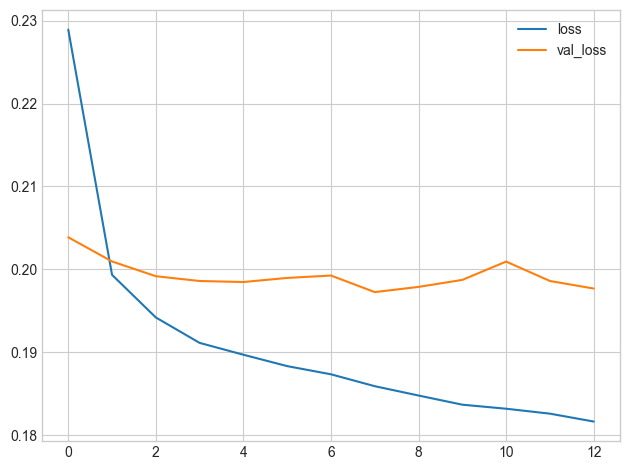

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Uvježbavanje i tumačenje

Je li to bilo poboljšanje u usporedbi s treningom bez ranog prekida?

-Dovelo je do poboljšanja.

Ako želite, pokušajte eksperimentirati s `patience` i `min_delta` da vidite kakvu bi razliku moglo napraviti.

# Nastavi #

Prijeđite na [**sljedeću vježbu**](Dropout_and_Batch_Normalization_hr.ipynb): batch normalization i dropout.